# SRGAN Implemetation Code

## Importing Libraries

In [154]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

import tensorflow_addons as tfa
from tensorflow.keras.layers import RandomCrop
import tensorflow_transform as tft
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras import Model
from keras.layers import Conv2D
from keras import Input
from keras.layers import PReLU,LeakyReLU
from keras.layers import UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import add,Dense, Flatten
from keras import activations

from tqdm import tqdm
from keras.models import load_model
import keras
import keras.utils
from keras import utils as np_utils
import keras.backend as K
import numpy as np 

In [155]:
image_paths = []
count = 0

for root, _, files in os.walk('/kaggle/input/image-dataset'):
    for file in files:
        if file.endswith(".jpg"):
            image_paths.append(os.path.join(root, file))
            count += 1

print("Total number of .jpg images:", count)

Total number of .jpg images: 82783


# Data generator and the preprocessing 

In [156]:
randomcrop1 = RandomCrop(96,96)
min_maxScale = tf.keras.layers.Rescaling(scale= 1./255)
range_Scaling = tf.keras.layers.Rescaling(scale= 1./127.5,offset=-1)
def prepare_Image_tf(imgPath): 
    # Read the image
    '''img = tf.io.read_file(imgPath)
    img = tf.image.decode_jpeg(img, channels=0)'''
    img = tf.keras.utils.load_img(
    imgPath,
    grayscale=False,
    color_mode='rgb',
    )
    
    HR = randomcrop1(img)
    
    # constructing the LR images 
    LR= tfa.image.gaussian_filter2d(image= HR,
        filter_shape = (3, 3),
        sigma = 1.0,
        padding = 'REFLECT')
    
    LR = tf.image.resize(LR, [24, 24])
    LR = min_maxScale(LR)
    
    # Normalizing the HR images 
    HR = range_Scaling(HR)
    return LR,HR

In [157]:
def get_batch(get_image= prepare_Image_tf,dataset=ImgDataset,batch_size=16): 
    HR_batch=[]
    LR_batch=[]
    for counter,path in enumerate(dataset):
        LR,HR=get_image(path)
        HR_batch.append(HR)
        LR_batch.append(LR)
        if (counter+1)%batch_size == 0: 
            yield tf.stack(LR_batch),tf.stack(HR_batch)
            HR_batch=[]
            LR_batch=[]

# Sample visualization from the dataset 

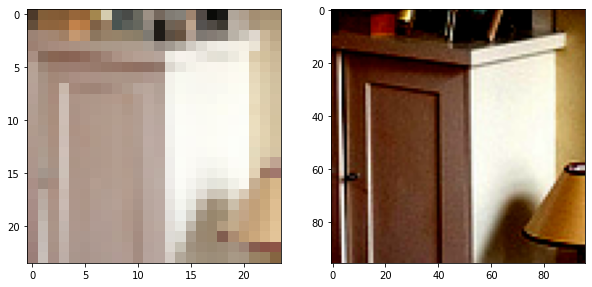

In [158]:
data_loader = get_batch()
low_res_batch,high_res_batch = next(data_loader)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(low_res_batch[8])
plt.subplot(1,2,2)
plt.imshow(high_res_batch[8])

# Model Building

## Discriminative Model

In [159]:
def repeated_block(input_tensor,channels,strides):
    block= Conv2D(channels,(3,3),padding='same',strides=(strides,strides))(input_tensor)
    bn= BatchNormalization(axis = -1)(block)
    activation= LeakyReLU(alpha=0.2)(bn)
    return activation

def descriminator(input_tensor):
    filters=64
    Block = Conv2D(64,(3,3),padding='same')(input_tensor)
    Block = LeakyReLU(alpha=0.2)(Block)
    layer= repeated_block(Block,filters,2)
    for i in range(3):
        filters*=2
        layer= repeated_block(layer,filters,1)
        layer= repeated_block(layer,filters,2)

    flattened= Flatten()(layer)
    layer2= Dense(1024)(flattened)
    layer3= LeakyReLU(alpha=0.2)(layer2)
    output= Dense(1,activation=activations.sigmoid)(layer3)
    return Model(inputs=input_tensor, outputs=output)

## Generative model 

In [160]:
def upscale_block(input_tensor):
    Block=Conv2D(256,(3,3),padding='same',use_bias=False)(input_tensor)
    Block2=UpSampling2D(size=2)(Block)
    Block3=PReLU(shared_axes=[1, 2])(Block2)
    return Block3

In [161]:
def res_block(input_tensor):

    Block=Conv2D(64,(3,3),padding='same',use_bias=False)(input_tensor)
    BN=BatchNormalization(axis=-1)(Block)
    ACTIV=PReLU(shared_axes=[1, 2])(BN)
    Block2=Conv2D(64,(3,3),padding='same')(ACTIV)
    BN2=BatchNormalization(axis=-1)(Block2)

    return add([input_tensor,BN2])


In [169]:
def GAN_generator(INPUT):
    Block=Conv2D(64,(9,9),padding='same')(INPUT)
    layer=PReLU(shared_axes=[1, 2])(Block)
  
    #change
    layer2= resBlock(layer)
    for i in range(15):
        layer2= resBlock(layer2)
  
    Block2=Conv2D(64,(3,3),padding='same')(layer2)
    BN3=BatchNormalization(momentum=0.85)(Block2)
    layer3= add([layer,layer2])

    layer4= upScaleBlock(layer3)
    layer4= upScaleBlock(layer4)

    op=Conv2D(3,(9,9),padding='same')(layer4)
    return Model(inputs=INPUT,outputs=op)

### VGG19 

In [163]:
def create_vgg19(input_shape):
    
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    output_layer = vgg.layers[20].output
    model = Model(inputs=vgg.input, outputs=output_layer)
    model.trainable = False

    return model

vgg19_model = create_vgg19((96, 96, 3))


## linking GAN networks 

In [165]:
def Link_GAN(generator, discriminator, vgg, lr_shape, hr_shape):
    
    lr_input = Input(shape=lr_shape)
    hr_input = Input(shape=hr_shape)
    generated_image = generator(lr_input)
    generated_features = vgg(generated_image)
    discriminator.trainable = False
    validity = discriminator(generated_image)
    gan_model = Model(inputs=[lr_input, hr_input], outputs=[validity, generated_features])
    
    return gan_model


# Training the model 

In [ ]:
LR = Input(shape=(24,24,3))
HR = Input(shape=(96,96,3))
## Generator
generator_model = GAN_generator(LR)
generator_model.summary()

In [ ]:
## Discriminator
discriminator_model = descriminator(HR)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

discriminator_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
discriminator_model.summary()

In [ ]:
#Linking the models
GAN = Link_GAN(generator_model, discriminator_model, vgg19, LR, HR)
GAN.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer=optimizer)
GAN.summary()

## Images after passing to the generator model

In [ ]:
generator_model = load_model('/kaggle/input/SRGAN-Weights-20EPOCH-coco/gen_e_20.h5', compile=False)


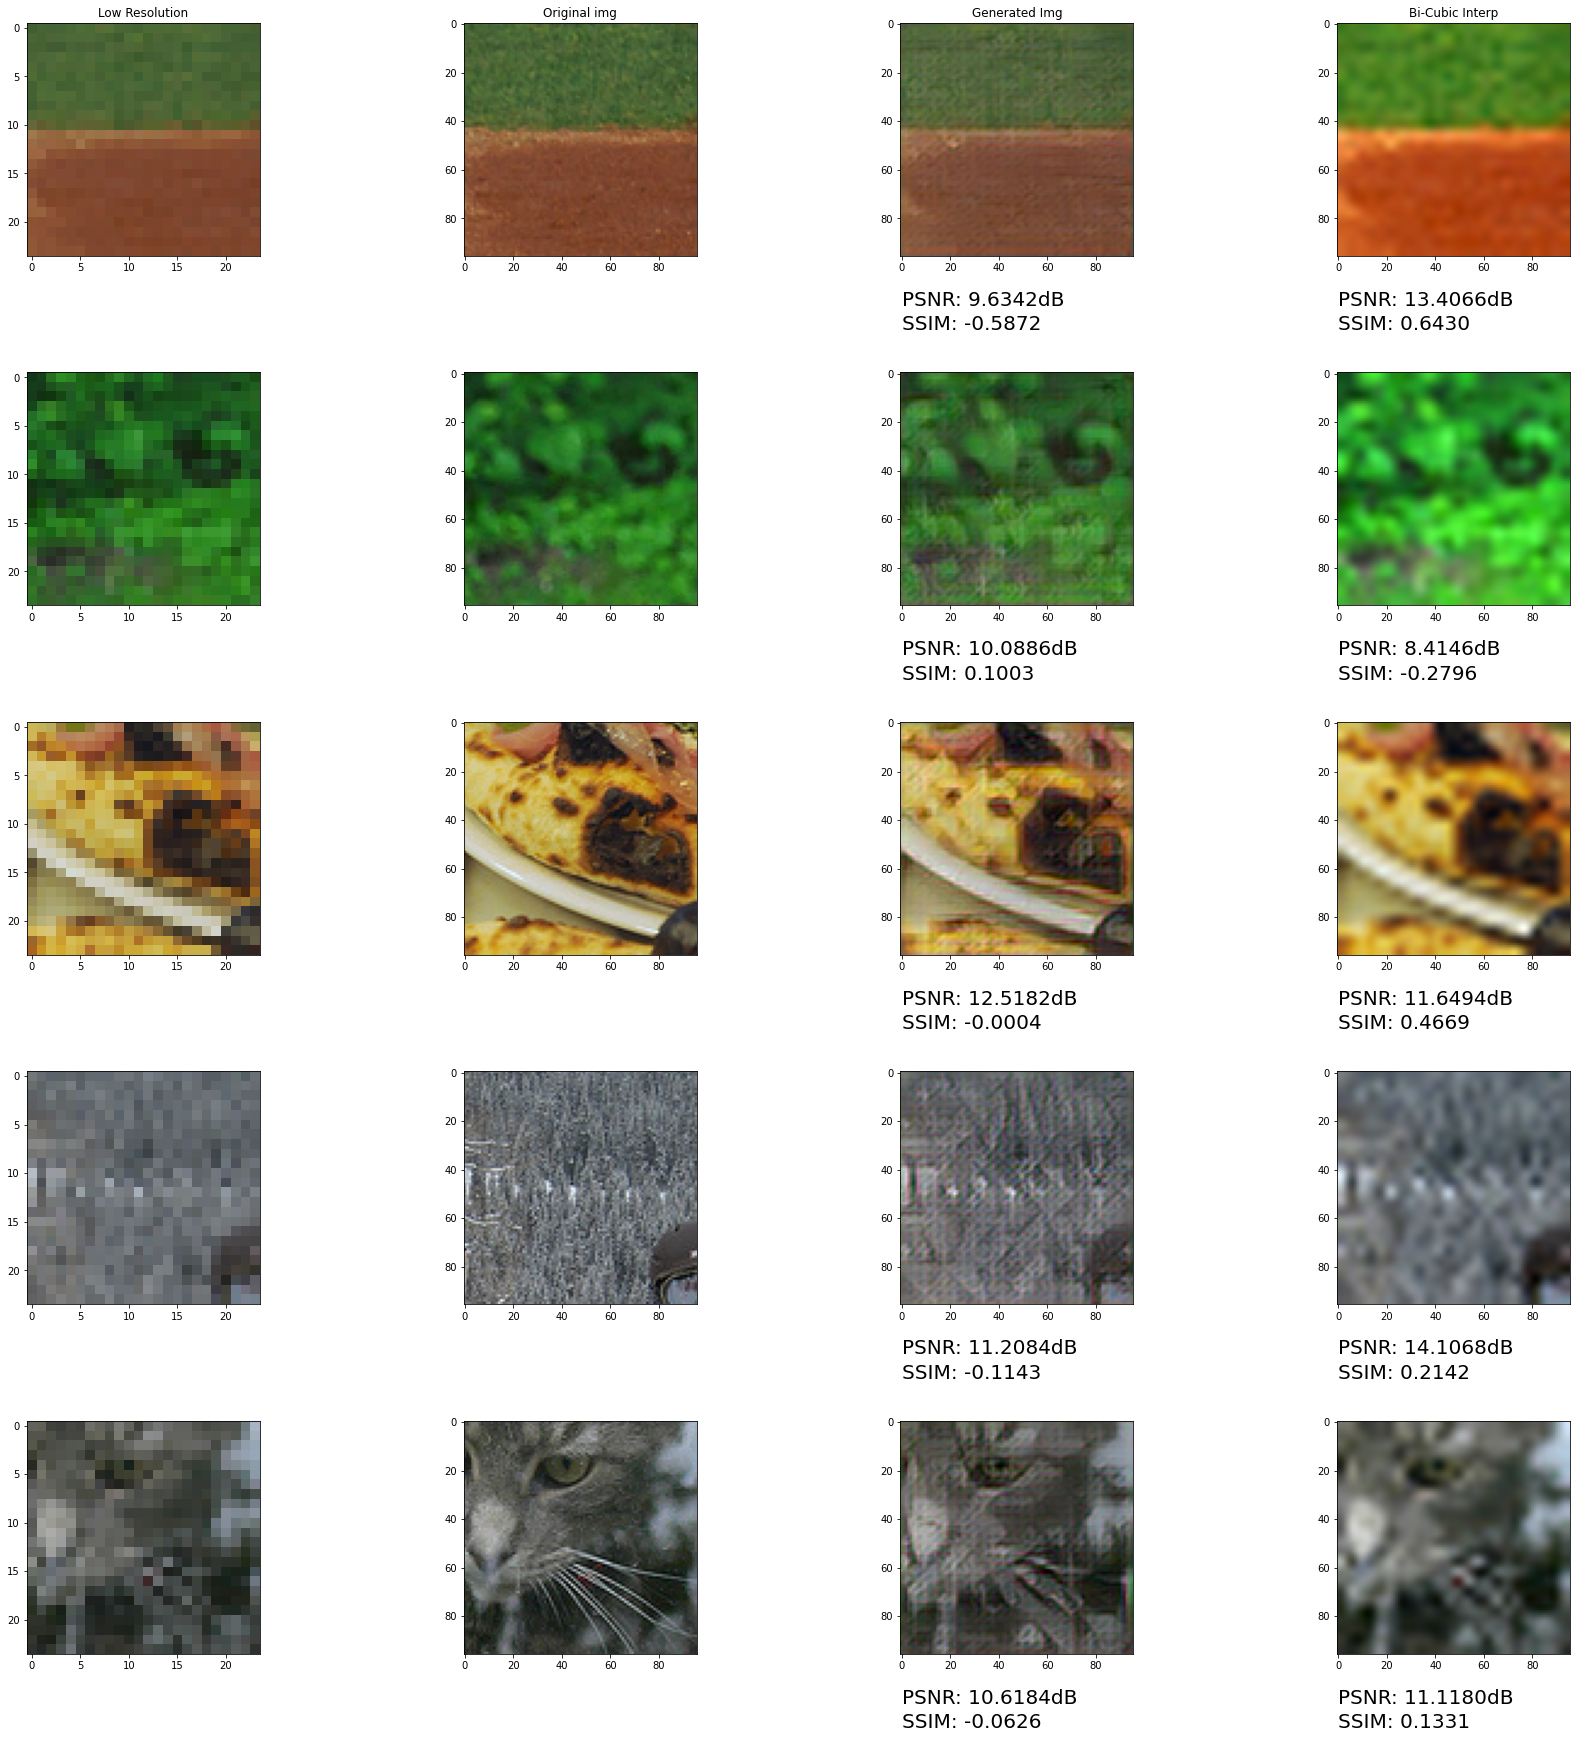

In [171]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.transform import resize

def calculate_metrics(hr_image, upscaled_image):
    # Ensure dimensions match
    hr_image = resize(hr_image, upscaled_image.shape, order=3, mode='edge', anti_aliasing=True)

    # Calculate SSIM, PSNR, and MSE for HR vs Upscaled
    ssim_hr_upscaled, _ = ssim(hr_image, upscaled_image, full=True, win_size=3)
    psnr_hr_upscaled = psnr(hr_image, upscaled_image,data_range=upscaled_image.max() - upscaled_image.min())
    mse_hr_upscaled = np.mean((hr_image - upscaled_image) ** 2)

    return ssim_hr_upscaled, psnr_hr_upscaled, mse_hr_upscaled
plt.figure(figsize=(30,30)) 
plt.subplots_adjust(hspace=0.5)
for i in range(5):
    idx = random.randint(0, len(ImgDataset))
    lr, hr = prepare_Image_tf(ImgDataset[idx])
    
    # plotting the LR img
    plt.subplot(5,4,i*4+1)
    plt.imshow(lr)
    if i == 0:
        plt.title("Low Resolution")

    # plotting the original img 
    plt.subplot(5,4,i*4+2)
    plt.imshow((hr + 1) / 2)
    if i == 0:
        plt.title("Original img")
    
    # now plotting the recovered image
    hr = hr + 1 / 2
    fake_imgs = generator_model.predict(tf.expand_dims(lr, axis=0))  # Using generator_model
    plt.subplot(5,4,i*4+3)    
    plt.imshow((fake_imgs[0] + 1) / 2)
    ssim_hr_upscaled, psnr_hr_upscaled, mse_hr_upscaled = calculate_metrics(hr, fake_imgs[0])
    center_x = 0
    center_y = 96
    plt.text(center_x, center_y + 20, f'PSNR: {psnr_hr_upscaled:.4f}dB', fontsize=20)
    plt.text(center_x, center_y + 30, f'SSIM: {ssim_hr_upscaled:.4f}', fontsize=20)
    if i == 0:
        plt.title("Generated Img")
    
    # plotting the normal cubic interpolation 
    hr1 = cv2.resize(lr.numpy(), dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
    hr1 = cv2.normalize(np.array(hr1), 0, 1, dtype=cv2.CV_32F, norm_type=cv2.NORM_MINMAX)
    ssim_hr_upscaled, psnr_hr_upscaled, mse_hr_upscaled = calculate_metrics(hr, hr1)   
    plt.subplot(5,4,i*4+4)
    plt.imshow(hr1) 
    plt.text(center_x, center_y + 20, f'PSNR: {psnr_hr_upscaled:.4f}dB', fontsize=20)
    plt.text(center_x, center_y + 30, f'SSIM: {ssim_hr_upscaled:.4f}', fontsize=20) 
    if i == 0:
        plt.title("Bi-Cubic Interp")


## Contributions
### K.Moulika - code for Data generator and preprocessing and data visualization of data set 
### G.Vandana - code for discriminator model building 
### V.Pooja - code for Generative model building
### V.Ramya - code for Images after passing to the generator model
### N.Sanskruti - code for losses(vgg) and model training